In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [2]:
data = pd.read_csv("./data/diabetes.csv")
df = data.copy()

In [3]:
def check_df(dataframe: object, head: object = 5) -> object:
    print("########################### Shape ###########################")
    print(dataframe.shape)

    print("########################### Types ###########################")
    print(dataframe.dtypes)

    print("########################### Head ###########################")
    print(dataframe.head(head))

    print("########################### Tail ###########################")
    print(dataframe.tail(head))

    print("########################### NA ###########################")
    print(dataframe.isnull().sum())

    print("########################### Quantiles ###########################")
    print(dataframe.quantile([0, 0.05,0.1, 0.25, 0.50,0.75, 0.90, 0.95, 0.99, 1]).T)

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


   Outcome  Ratio
0      500 65.104
1      268 34.896


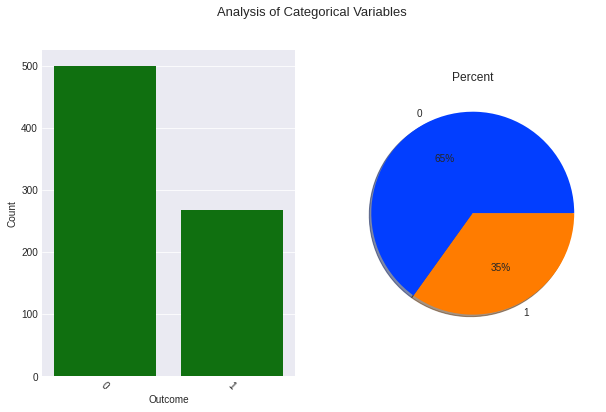

In [5]:
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        plt.style.use('seaborn-darkgrid')
        fig, ax = plt.subplots(1, 2)
        ax = np.reshape(ax, (1, 2))
        ax[0, 0] = sns.countplot(x=dataframe[col_name], color="green", ax=ax[0, 0])
        ax[0, 0].set_ylabel('Count')
        ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=-45)
        ax[0, 1] = plt.pie(dataframe[col_name].value_counts().values, labels=dataframe[col_name].value_counts().keys(),
                           colors=sns.color_palette('bright'), shadow=True, autopct='%.0f%%')
        plt.title("Percent")
        fig.set_size_inches(10, 6)
        fig.suptitle('Analysis of Categorical Variables', fontsize=13)
        plt.show()


for col in cat_cols:
    cat_summary(df, col, plot=True)

## Analysis of Numerical Variables

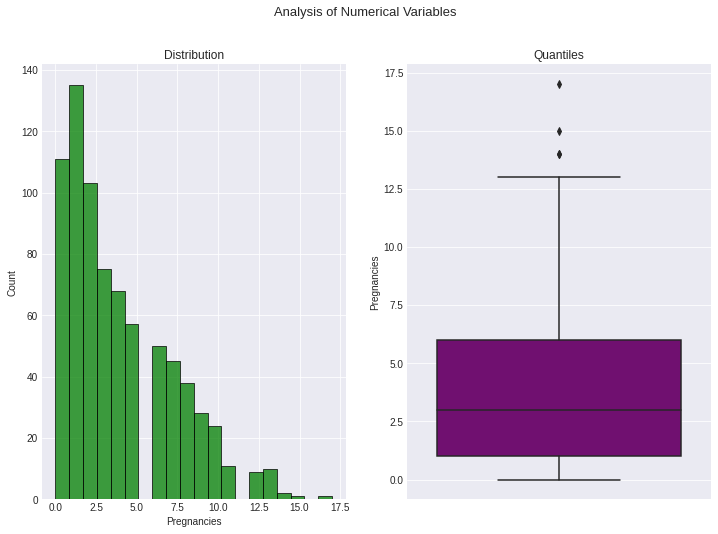

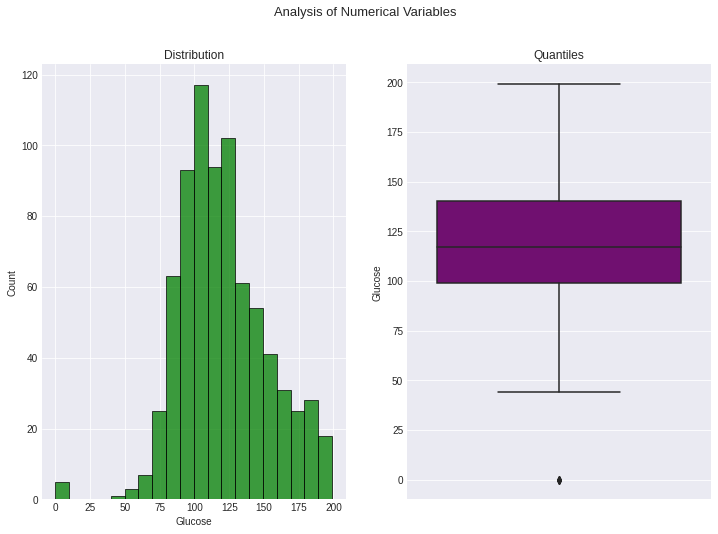

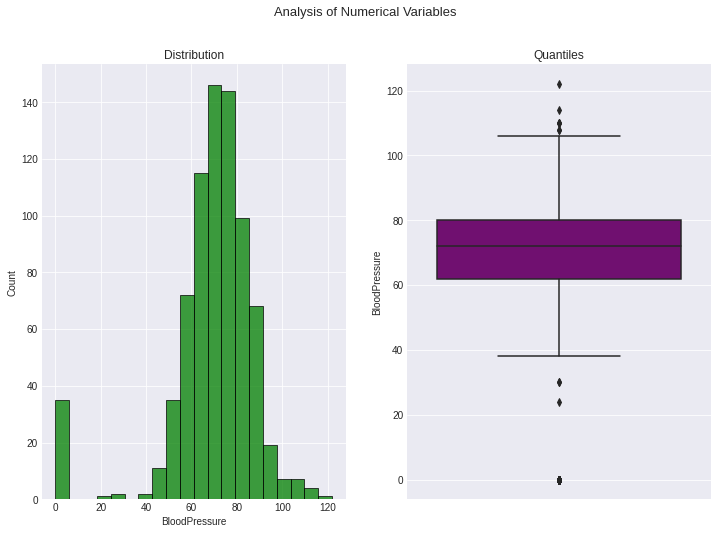

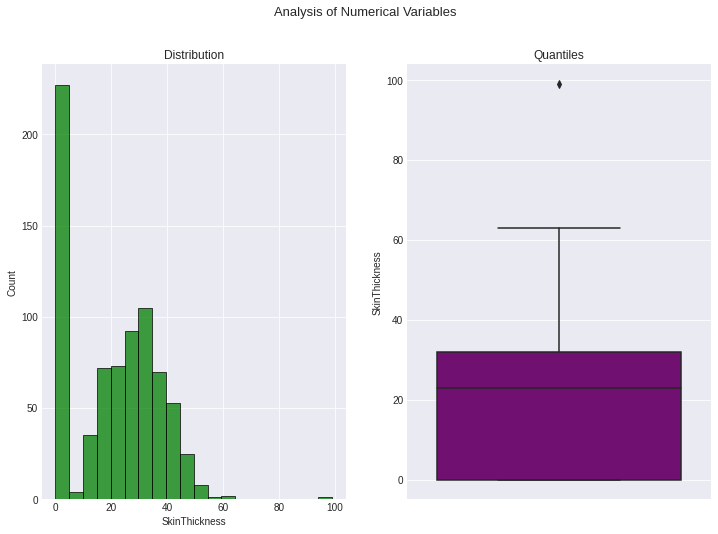

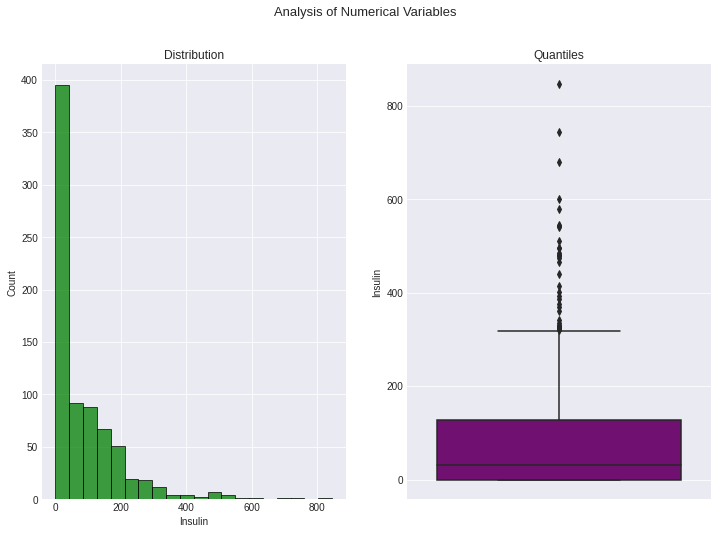

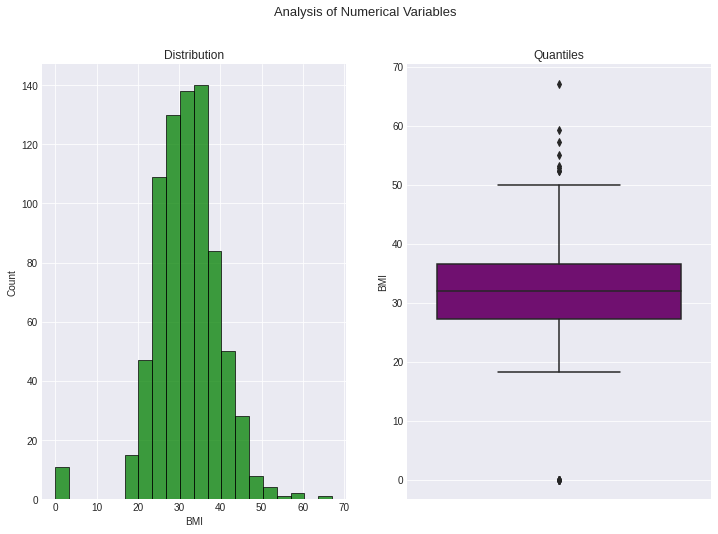

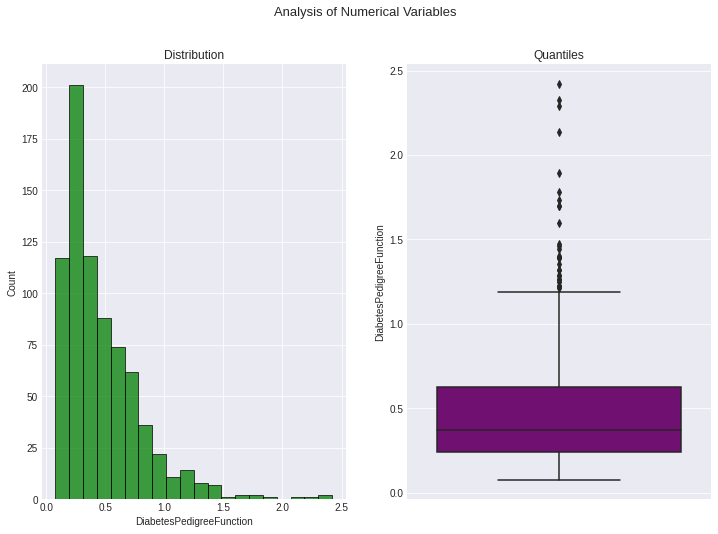

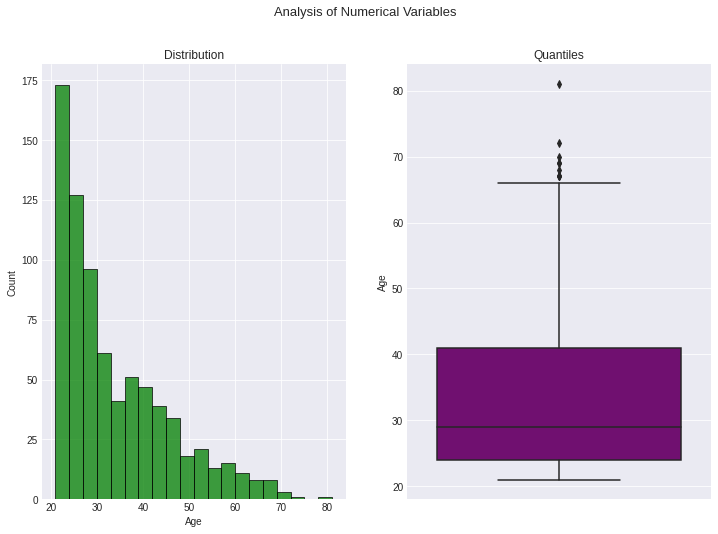

In [6]:
def num_summary(dataframe, numerical_col):
    # setup the plot grid
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(1, 2)
    ax = np.reshape(ax, (1, 2))
    ax[0, 0] = sns.histplot(x=dataframe[numerical_col], color="green", bins=20, ax=ax[0, 0])
    ax[0, 0].set_ylabel('Count')
    ax[0, 0].set_title('Distribution')
    ax[0, 1] = sns.boxplot(y=dataframe[numerical_col], color="purple", ax=ax[0, 1])
    ax[0, 1].set_title('Quantiles')

    fig.set_size_inches(12, 8)
    fig.suptitle('Analysis of Numerical Variables', fontsize=13)
    plt.show()

for col in df[num_cols]:
    num_summary(df, col)

## Analysis of Correlation

<a id = "6"></a><h1 id="Data Preprocessing"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; color: Black; ">Data Preprocessing</span></h1>

## Missing Values

In [7]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
    
missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

## Outliers

In [8]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

for col in num_cols:
    print(outlier_thresholds(df, col))

(-15.0, 25.0)
(-74.0, 334.0)
(-38.249999999999986, 166.95)
(-66.0, 110.0)
(-439.5, 732.5)
(-12.09249999999999, 78.2875)
(-1.3483999999999996, 2.621599999999999)
(-34.5, 113.5)


In [9]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df,col)

## Label Encoding

In [10]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
len(binary_cols)

0

In [11]:
for col in binary_cols:
    label_encoder(df, col)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000,148.000,72.000,35.000,0.000,33.600,0.627,50.000,1
1,1.000,85.000,66.000,29.000,0.000,26.600,0.351,31.000,0
2,8.000,183.000,64.000,0.000,0.000,23.300,0.672,32.000,1
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1


## One-Hot Encoding

In [12]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols, drop_first=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000,148.000,72.000,35.000,0.000,33.600,0.627,50.000,1
1,1.000,85.000,66.000,29.000,0.000,26.600,0.351,31.000,0
2,8.000,183.000,64.000,0.000,0.000,23.300,0.672,32.000,1
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1


In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


## Standart Scaler

In [14]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

#check_df(df)

In [15]:
from enhance_data import enhance_data

In [16]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

fitting new generator on smaller data
Epoch 001 | ET 0.01 min | Avg Losses >> G/D 0.8299/1.5746 [D-Real: 0.8216 D-Fake: 0.7531]
Epoch 002 | ET 0.03 min | Avg Losses >> G/D 0.7782/1.4726 [D-Real: 0.7565 D-Fake: 0.7162]
Epoch 003 | ET 0.04 min | Avg Losses >> G/D 0.8083/1.4996 [D-Real: 0.7857 D-Fake: 0.7139]
Epoch 004 | ET 0.05 min | Avg Losses >> G/D 0.7931/1.4567 [D-Real: 0.7689 D-Fake: 0.6878]
Epoch 005 | ET 0.05 min | Avg Losses >> G/D 0.7910/1.5064 [D-Real: 0.8187 D-Fake: 0.6877]
Epoch 006 | ET 0.06 min | Avg Losses >> G/D 0.8025/1.5231 [D-Real: 0.8478 D-Fake: 0.6753]
Epoch 007 | ET 0.07 min | Avg Losses >> G/D 0.8125/1.4957 [D-Real: 0.8359 D-Fake: 0.6599]
Epoch 008 | ET 0.08 min | Avg Losses >> G/D 0.8313/1.4848 [D-Real: 0.8375 D-Fake: 0.6473]
Epoch 009 | ET 0.09 min | Avg Losses >> G/D 0.8530/1.4407 [D-Real: 0.8030 D-Fake: 0.6377]
Epoch 010 | ET 0.10 min | Avg Losses >> G/D 0.8339/1.4638 [D-Real: 0.8274 D-Fake: 0.6364]
Epoch 011 | ET 0.11 min | Avg Losses >> G/D 0.8033/1.4133 [D-R

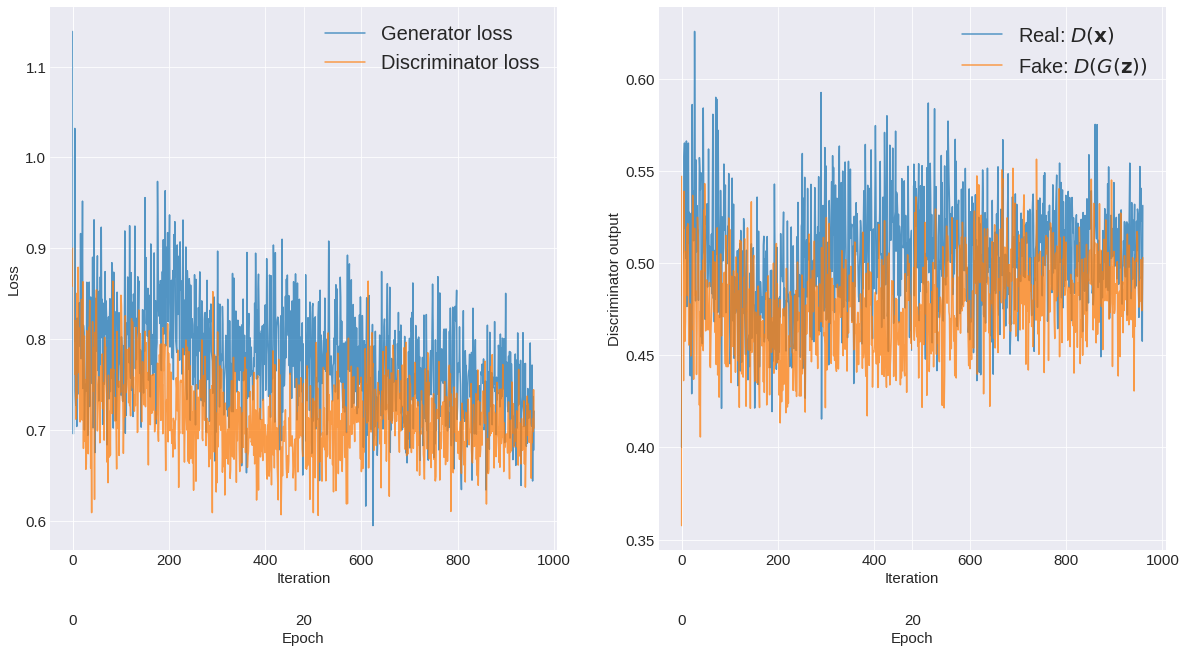

In [17]:
enh = enhance_data(x_train=X, y_train=y, force_generator=True, synthetic_share=.1)

In [18]:
log_model_s = LogisticRegression().fit(enh['x_train_processed'], enh['y_train'])

## Model Validation: 10-Fold Cross Validation

In [19]:
cv_results = cross_validate(log_model,
                            X, y,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [20]:
cv_results_s = cross_validate(log_model_s,
                            X, y,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

## Predict

In [21]:
y_pred = log_model.predict(X)

In [22]:
y_pred_s = log_model_s.predict(X)

/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Model Evaluation

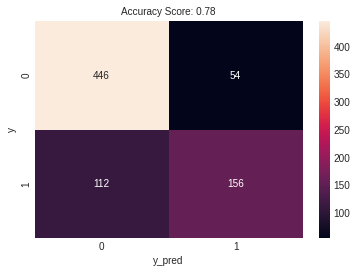

In [23]:
# Confusion Matrix
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

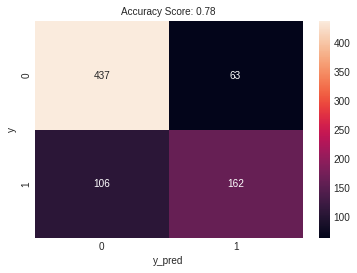

In [24]:
plot_confusion_matrix(y, y_pred_s)

In [25]:
# Başarı skorları:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [26]:
# Başarı skorları:
print(classification_report(y, y_pred_s))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84       500
           1       0.72      0.60      0.66       268

    accuracy                           0.78       768
   macro avg       0.76      0.74      0.75       768
weighted avg       0.78      0.78      0.77       768



In [27]:
# ROC AUC
y_prob = log_model_s.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.8393955223880596

In [28]:
# ROC AUC
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.839358208955224

In [29]:
# Prediction for A New Observation

X.columns

random_user = X.sample(1, random_state=42)

log_model.predict(random_user)

array([0])

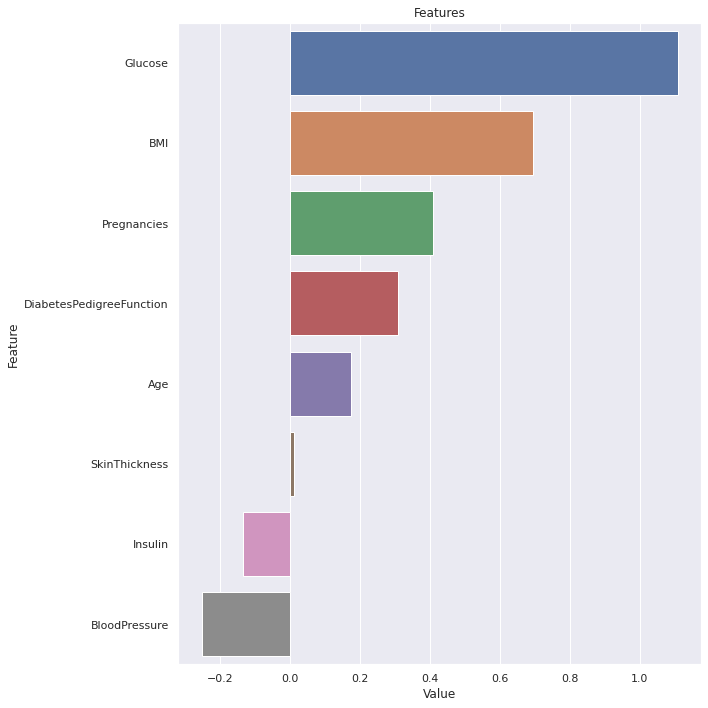

In [30]:
feature_imp = pd.DataFrame({'Value': log_model.coef_[0], 'Feature': X.columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:8])
plt.title('Features')
plt.tight_layout()
plt.show()

![](https://i.pinimg.com/474x/c2/4f/c2/c24fc21a2ba2f9e8847616ae0424788f.jpg)